<a href="https://colab.research.google.com/github/kiddojazz/PythonCode/blob/master/Transformers_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-l73f6ika
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-l73f6ika
  Resolved https://github.com/huggingface/transformers.git to commit d8e13b3e04da9e61c6f16df43815656f59688abd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.1 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.34.0.dev0-py3-none-any.whl size=7636963 sha256=598e414880f7fba25c31ca8276e5cc6c8784c2176b24d95c42b240c776e1bb98
  Stored in directory: /tmp/pip-ephem-wheel-cache-yvj1k71d/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16


In [43]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
import tensorflow as tf
import pandas as pd
import json
import gc

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
#Navigate to the file directory and read the pokemon file in your Google Drive

inventory_df = pd.read_excel("/content/drive/MyDrive/Inventory/data_test.xlsx")
inventory_df.head()

,Task Plan,Description,Category
0,ADM-EOP-0001,Seplat Soccer Tournament,Service
1,ADM-EOP-0002,Seplat Decluttering Exercise,Service
2,AST-FFE-0001,Independent Fire Water Systems,Material
3,AST-FFE-0002,Fire Extinguishers,Material
4,AST-FFE-0003,Mobilisation,Unlabelled


In [5]:
#Filter Out the Unlabelled Values
inventory_df = inventory_df[(inventory_df['Category'] == 'Material') | (inventory_df['Category'] == 'Service')]

In [44]:
inventory_df['Category'].unique()

array(['Service', 'Material'], dtype=object)

In [7]:
inventory_df['encoded_cat'] = inventory_df['Category'].astype('category').cat.codes
inventory_df.head()

,Task Plan,Description,Category,encoded_cat
0,ADM-EOP-0001,Seplat Soccer Tournament,Service,1
1,ADM-EOP-0002,Seplat Decluttering Exercise,Service,1
2,AST-FFE-0001,Independent Fire Water Systems,Material,0
3,AST-FFE-0002,Fire Extinguishers,Material,0
5,AST-FFE-0004,Engineering Design,Service,1


In [8]:
#inventory_df.drop(['Task Plan'], 1, inplace=True) XXX
inventory_df = inventory_df.drop(columns='Task Plan') # Pandas official way of dropping columns
inventory_df.head(20)

,Description,Category,encoded_cat
0,Seplat Soccer Tournament,Service,1
1,Seplat Decluttering Exercise,Service,1
2,Independent Fire Water Systems,Material,0
3,Fire Extinguishers,Material,0
5,Engineering Design,Service,1
7,Supply and installation of Braithwaite Pitched...,Service,1
8,Foundation & Structural Works,Service,1
9,Borehole Drilling & Pipe Works,Service,1
10,Procurement & Installation - Submersible Pump,Service,1
11,Procurement & Installation - Booster Pump,Service,1


In [9]:
data_texts = inventory_df["Description"].to_list() # Features (not-tokenized yet)
data_labels = inventory_df["encoded_cat"].to_list() # Lables

In [10]:
from sklearn.model_selection import train_test_split

# Split Train and Validation data
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0, shuffle=True)

# Keep some data for inference (testing)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.01, random_state=0, shuffle=True)

In [11]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

In [13]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

#optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
#model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [40]:
model.fit(train_dataset.shuffle(1000).batch(16), epochs=1, batch_size=16,
          validation_data=val_dataset.shuffle(1000).batch(16))

1468/1468 [==============================] - 162s 110ms/step - loss: 0.0377 - accuracy: 0.9872 - val_loss: 0.1014 - val_accuracy: 0.9742


In [46]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(train_dataset.shuffle(1000).batch(16),
          epochs=3,
          batch_size=16,
          validation_data=val_dataset.shuffle(1000).batch(16),
          callbacks=[early_stopping])


Epoch 1/3
1468/1468 [==============================] - 160s 109ms/step - loss: 0.0285 - accuracy: 0.9908 - val_loss: 0.1021 - val_accuracy: 0.9764
Epoch 2/3
1468/1468 [==============================] - 160s 109ms/step - loss: 0.0254 - accuracy: 0.9915 - val_loss: 0.0947 - val_accuracy: 0.9757
Epoch 3/3
1468/1468 [==============================] - 161s 110ms/step - loss: 0.0221 - accuracy: 0.9924 - val_loss: 0.1318 - val_accuracy: 0.9755


In [47]:
# Display the model's architecture
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,957,317
Trainable params: 66,957,317
Non-trainable params: 0
_________________________________________________________________


In [48]:
from tensorflow.keras.models import load_model

In [49]:
save_directory = "/content/drive/MyDrive/Inventory/tensorflow_model_3" # change this to your preferred location

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('/content/drive/MyDrive/Inventory/tensorflow_model_3/tokenizer_config.json',
 '/content/drive/MyDrive/Inventory/tensorflow_model_3/special_tokens_map.json',
 '/content/drive/MyDrive/Inventory/tensorflow_model_3/vocab.txt',
 '/content/drive/MyDrive/Inventory/tensorflow_model_3/added_tokens.json')

In [50]:
loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

Some layers from the model checkpoint at /content/drive/MyDrive/Inventory/tensorflow_model_3 were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/Inventory/tensorflow_model_3 and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
test_text = test_texts[10]
test_text

'Provide, Mix, Place And Compact Grade 40 Concrete Pile'

In [60]:
test_text = ['Fire Truck']

In [61]:
predict_input = loaded_tokenizer.encode(test_text,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

output = loaded_model(predict_input)[0]

prediction_value = tf.argmax(output, axis=1).numpy()[0]
prediction_value

1

In [62]:
predict_input = loaded_tokenizer.encode(test_text,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

output = loaded_model(predict_input)[0]

prediction_value = tf.argmax(output, axis=1).numpy()[0]

# Convert numeric prediction to category label
if prediction_value == 0:
    prediction_label = "Material"
else:
    prediction_label = "Service"  # Handle unexpected values if necessary

print("Predicted Category:", prediction_label)


Predicted Category: Service


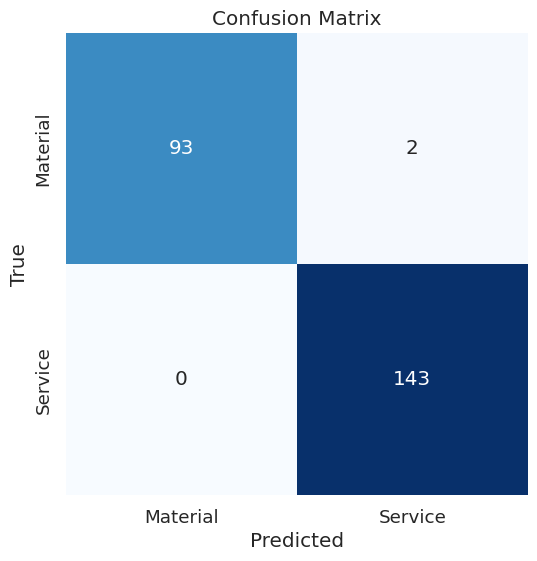

In [63]:
def predict_category(text):

    predict_input = loaded_tokenizer.encode(text,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

    output = loaded_model(predict_input)[0]

    prediction_value = tf.argmax(output, axis=1).numpy()[0]

    return prediction_value
# -----------------------------------------------------
y_pred = []
for texts in test_texts:
    y_pred.append(predict_category(texts))
# -------------------------------------------
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

confusion = confusion_matrix(test_labels, y_pred)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=["Material", "Service"], yticklabels=["Material", "Service"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [66]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        95
           1       0.99      1.00      0.99       143

    accuracy                           0.99       238
   macro avg       0.99      0.99      0.99       238
weighted avg       0.99      0.99      0.99       238



In [67]:
# Create a new column in the original DataFrame
inventory_df['Predictions'] = prediction_value

In [69]:
inventory_df.head(50)

,Description,Category,encoded_cat,Predictions
0,Seplat Soccer Tournament,Service,1,1
1,Seplat Decluttering Exercise,Service,1,1
2,Independent Fire Water Systems,Material,0,1
3,Fire Extinguishers,Material,0,1
5,Engineering Design,Service,1,1
7,Supply and installation of Braithwaite Pitched...,Service,1,1
8,Foundation & Structural Works,Service,1,1
9,Borehole Drilling & Pipe Works,Service,1,1
10,Procurement & Installation - Submersible Pump,Service,1,1
11,Procurement & Installation - Booster Pump,Service,1,1


In [74]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                # strength of weight decay
    eval_steps = 10,
    logging_dir='./logs',            # directory for storing logs
)

with training_args.strategy.scope():
    trainer_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

trainer = TFTrainer(
    model=trainer_model,                 # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [75]:
trainer.train()

In [76]:
trainer.evaluate()

{'eval_loss': 0.06668269249700731}

In [ ]:
save_directory = "/content/drive/MyDrive/Inventory/transformers_model_1" # change this to your preferred location

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

In [ ]:
loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(save_directory)